# Inf2 - Foundations of Data Science
## S1 Week 09: Scikit-learn - _k_-Nearest Neighbours

**Learning outcomes:** 
In this lab you will learn how to apply _k_-Nearest Neighbours (_k_-NN) to a data set using the scikit-learn library. By the end of the lab you should be able to:

- explain how _k_ can be chosen appropriately, 
- explain the importance between training, testing and validation data.

The end of semester is near, you have worked hard, and some might think about celebrating it with a nice dinner and a glass of wine (other beverages are available). In this lab, we will try to predict the quality of wine based on several characteristics, and test whether price alone is a good predictor of good wine.

**Data set information:** The data set is taken from [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality), but was originally used in [Cortez et al. 2009](https://www.sciencedirect.com/science/article/pii/S0167923609001377).

**Pair programming:** We encourage you to work in pairs again. Remember that the magic command you need to get the link for the session with your partner is:

In [1]:
!echo "https://noteable.edina.ac.uk/user/$(jupyter notebook list | grep -oP '(?<=user\/).*(?=\/\?)' )/tree?token=$( jupyter notebook list | grep -oP '(?<=token=).*(?= ::)' )"

https://noteable.edina.ac.uk/user/jbw4vzrioh3iptep96vrsa/tree?token=xU1TBLb-RNWAIK3AjQW58Q


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## A. About _k_-nearest neighbours

_k_-NN is a supervised machine learning algorithm. _k_-NN can be used for regression as well as classification problems. In this lab, we will use it for classification, as each wine has one of a number of distinct ratings that we want to predict.

Suppose we are presented with a previously unseen data point, but we do not know its class. _k_-nearest neighbours predicts that the class (or label) of this point depends on the labels of the _k_ data points closest to it.  This definition prompts two questions:

- How do we chose the number of neighbours?
- How do we weight the "votes" of each neighbour on the classification. It seems reasonable that a neighbour closer to the unseen data point should have a larger weight than one which is further away.

There are numerous ways to measure how "close" two data points are. A common choice is the Euclidean distance, which is the square root of the sum of squares of the different coordinates of two data points, or in a formula: 

$\mathrm{euclideanDistance}((x_1, y_1),(x_2, y_2))= \sqrt{ (x_1-x_2)^2+(y_1-y_2)^2 }$

However, there are many more options to chose from:
- Manhattan distance (sum of absolute values of differences between points)
- Minkowski distance (the generalization of the Euclidean distance and Manhattan distance, by taking the $p$-th root and $p$-th power of the differences)
- Cosine distance (looking at the angle formed by two points and the origin).

To get a better idea of what the cosine distance is, and how it differs to the Euclidean distance, we can recommend this [blog post](https://cmry.github.io/notes/euclidean-v-cosine).

**Exercise 01:**

Before we get into how to chose the value of $k$, let us think about an example where, depending on $k$, the assignment of the cluster to a new data point will change. You can assume for this exercise that we do not weight the importance of the data point differently depending on the distance to the queried point.

- Sketch on paper or plot a scatter plot that contains the following parts
  - a number of data points (training data) each of which is labeled with one of two classes (e.g. red and blue, or noughts and crosses)
  - a test data point (i.e. a data point with no label) that would be assigned to the red class for one value of $k$ (e.g. $k=1$) and the blue class for another value of $k$ (e.g. $k=3$)
  - two circles around the queried point, each of which encapsulates all the neighbours taken into account for two different values of $k$.

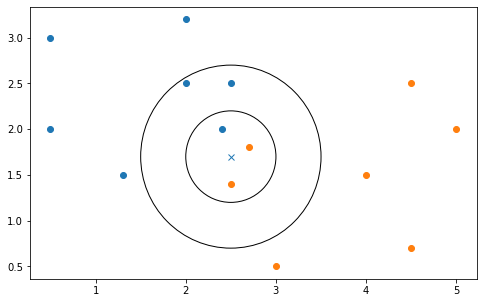

In [3]:
cluster_1_x = [0.5, 0.5, 1.3, 2.4, 2, 2, 2.5]
cluster_1_y = [2, 3, 1.5, 2, 2.5, 3.2, 2.5]
cluser_2_x = [2.5, 3, 2.7, 4, 4.5, 4.5, 5]
cluster_2_y = [1.4, 0.5, 1.8, 1.5, 0.7, 2.5, 2]
query = [2.5, 1.7]
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(cluster_1_x, cluster_1_y)
ax.scatter(cluser_2_x, cluster_2_y)
ax.plot(query[0], query[1], marker='x')
circle1 = plt.Circle((2.5, 1.7), 0.5, color='k', fill=False)
circle2 = plt.Circle((2.5, 1.7), 1, color='k', fill=False)
ax.add_patch(circle1)
ax.add_patch(circle2)
# This will assign the query point to cluster 2 with K=3, and to cluster 1 with K=5

**Discussion:**

Discuss with your lab partner what happens when you choose $k$ too small and what happens when you choose $k$ too large.

Your answer:

- Choosing $k$ too small leads to overfitting and your model will be susceptible to noise.
- Choosing $k$ too large leads to underfitting and your model will have a very simple boundary, and in the worst case consider all new data points as from the same class, which has most data entries in your data set.

We will try to answer these points in this lab.

## B. Data exploration and visualisation

**Exercise 02:**

- Load and examine the `'winequality-red.csv'` data set.

It has a column `'quality'` with values between 3 and 8. Our goal is to only differentiate between low quality, medium quality, and high quality.

- Print out how many data entries you have per quality score.

It seems like there are very few very poor and excellent wines.

- Edit the scores in your dataset, such that all wines with quality 3-5 get score 0, wines with scores 6 get score 1, and all wines with better scores get a score 2. 
- Print out how many wines are in each new category.

In [4]:
wine = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'winequality-red.csv'))
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
for score in range(3,9):
    print('There are ' + str(len(wine[wine['quality'] == score])) + ' wines with score ' + str(score))

# A one-line version of the abov is:
print(wine['quality'].value_counts())
    
wine.loc[wine.quality < 6, 'quality'] = 0
wine.loc[(wine.quality == 6), 'quality'] = 1
wine.loc[(wine.quality > 6), 'quality'] = 2


print('\nBased on the new scoring scheme:\n')
for score in range(0,3):
    print('There are ' + str(len(wine[wine['quality'] == score])) + ' wines with score ' + str(score))
    
# Or, a one-line version of the above:
print(wine['quality'].value_counts())

There are 10 wines with score 3
There are 53 wines with score 4
There are 681 wines with score 5
There are 638 wines with score 6
There are 199 wines with score 7
There are 18 wines with score 8
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Based on the new scoring scheme:

There are 744 wines with score 0
There are 638 wines with score 1
There are 217 wines with score 2
0    744
1    638
2    217
Name: quality, dtype: int64


**Exercise 03:**

- Visualise the edited data using a seaborn pairplot, using hue to indicate quality. (Note: this may take up to a minute to run.)
- Discuss how clear the distinction between the classes is visually.

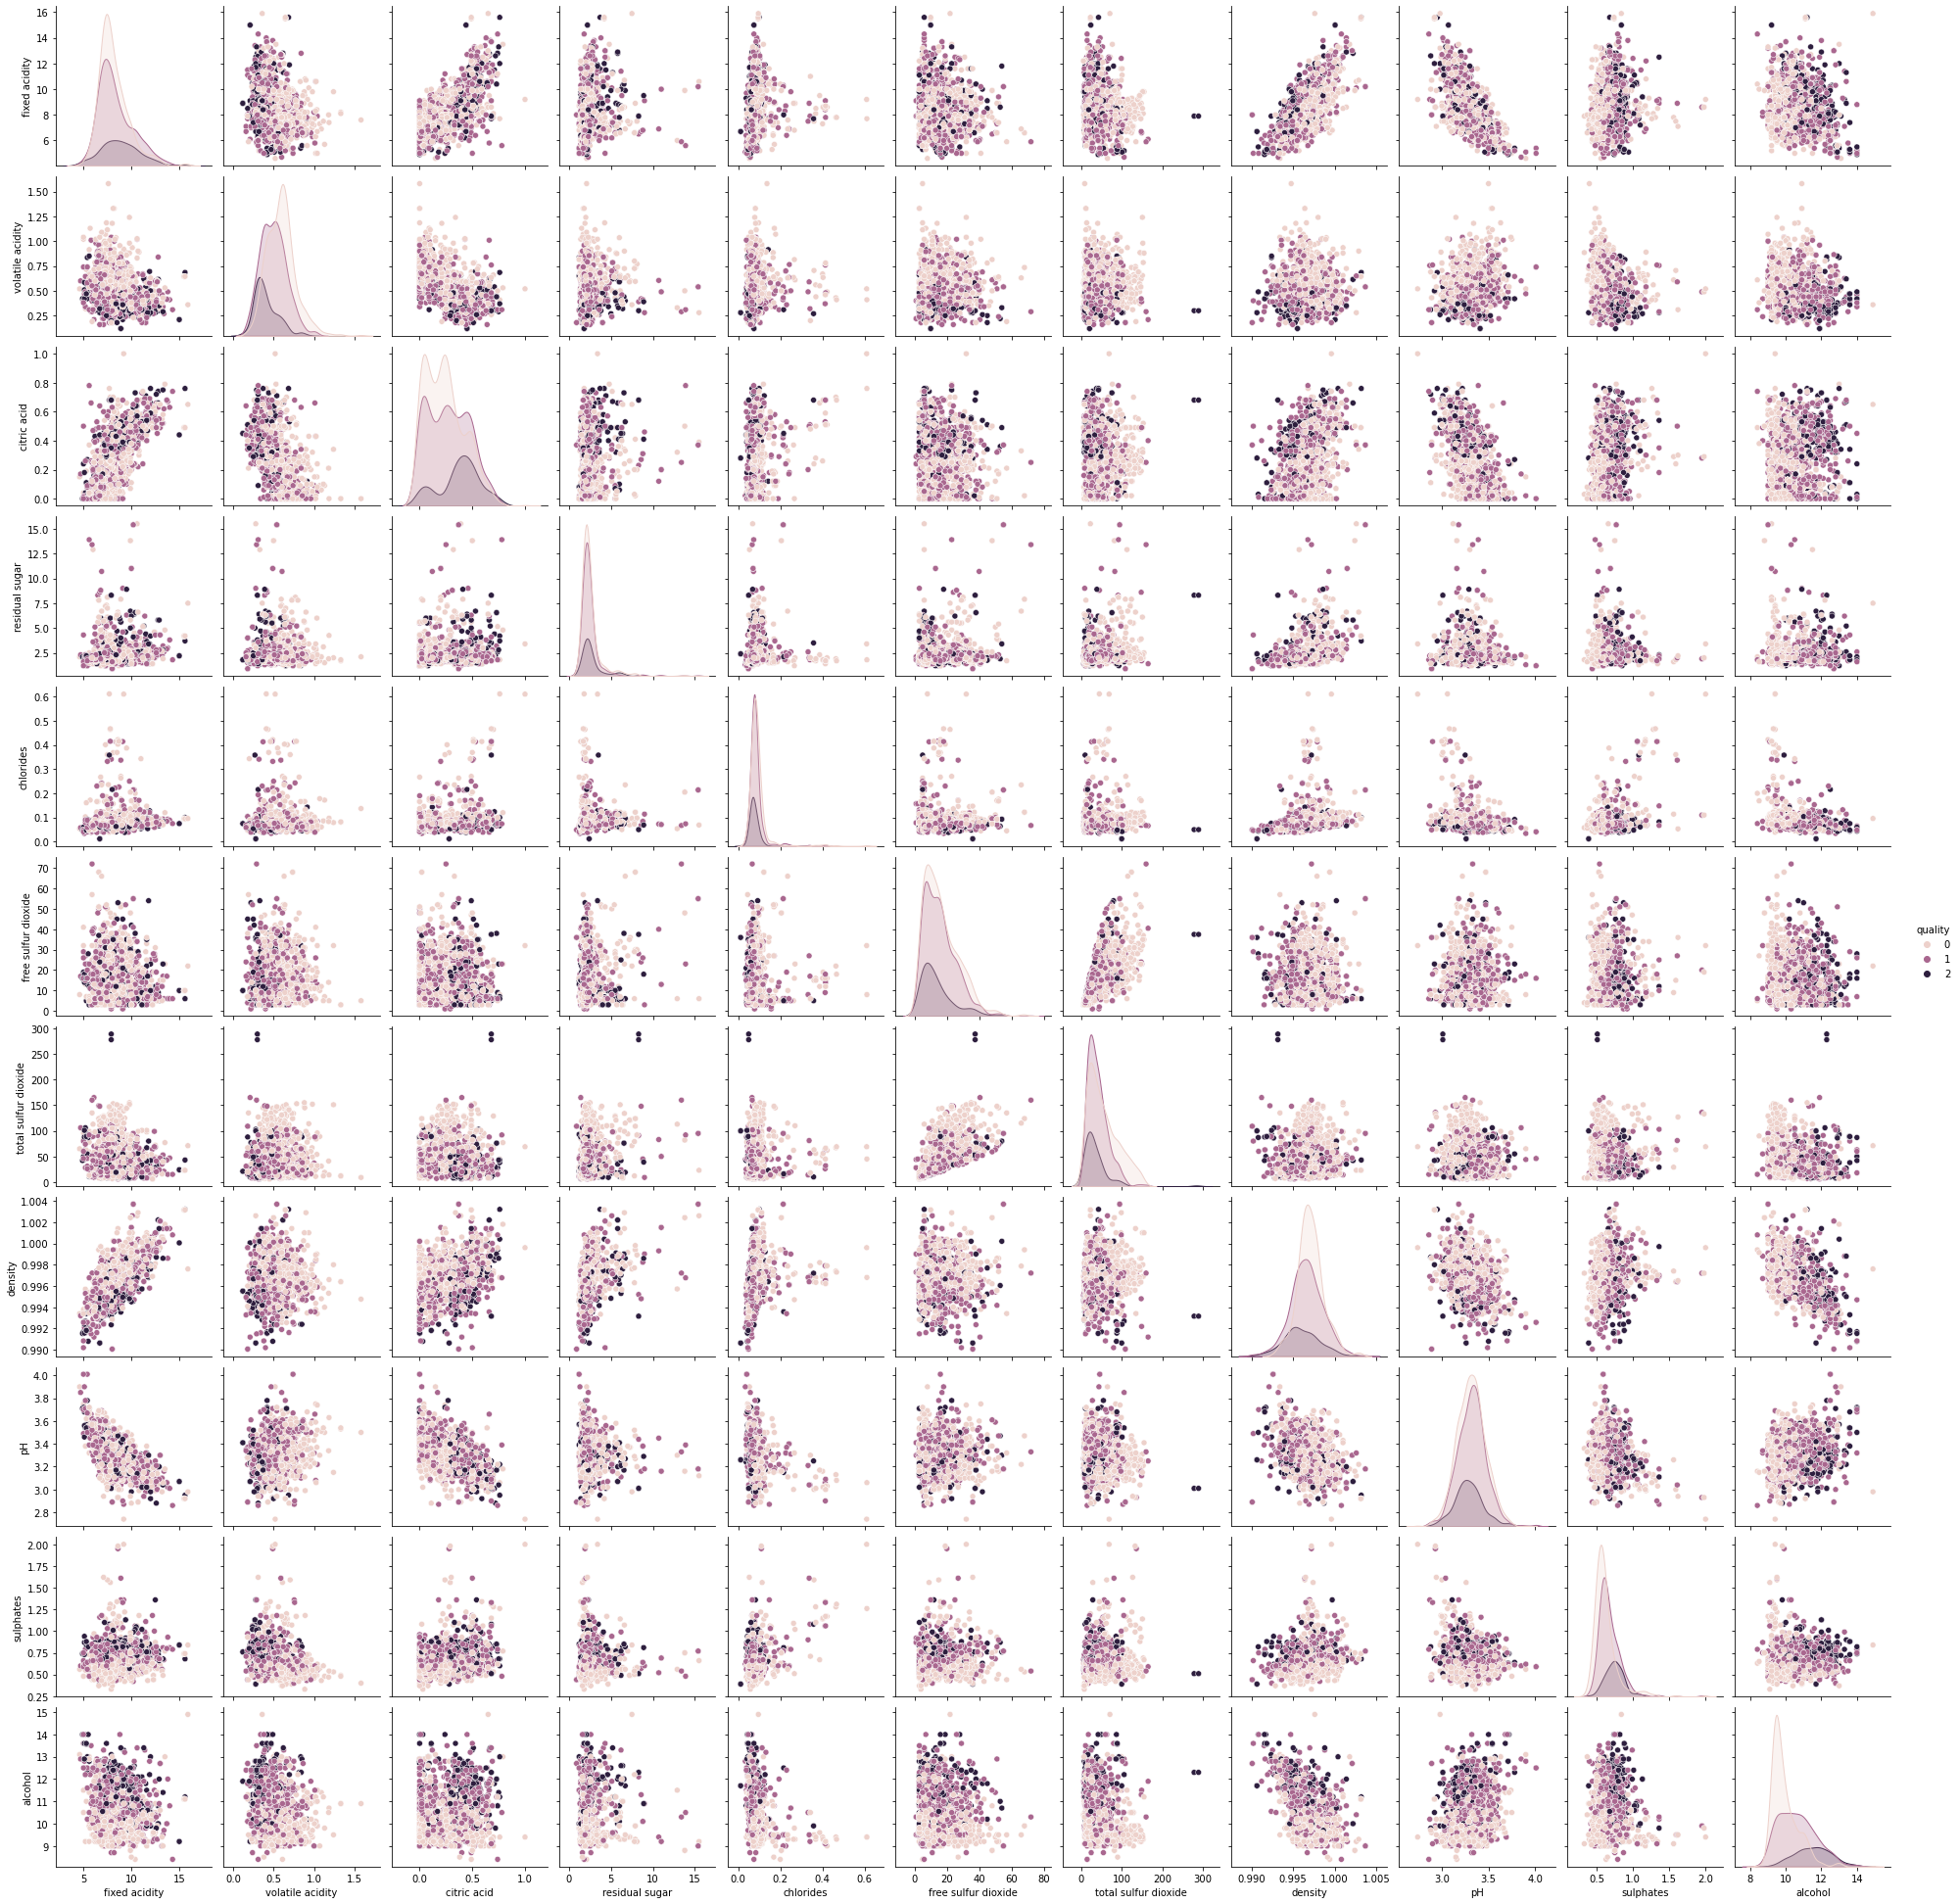

In [6]:
# Your code
sns.pairplot(data=wine, hue='quality')

- The distributions of some features (e.g. alcohol, sulphates and volatile acidity) appear to differ somewhat for the the different qualities.
- There doesn't appear to be any pair of features for which the three classes are neatly separated, but some pairs (e.g. free sulfur dioxide and alcohol) suggest that it might be possible to find decision boundaries that classify the data with some level of accuracy.

## C. Data preparation

In order to use scikit-learn's supervised learning algorithms, we need to separate data into features and labels. 

**Exercise 04:**

- Store the `quality` score column (the label) in a new series, which you could call `wine_label`.
- Store the features (i.e. every column apart from `quality`) in a new data frame, which you could call `wine_features`

In [7]:
# Your code
wine_labels = wine['quality']
wine_features = wine.drop(columns=['quality'])

## D. Standardisation

It often makes sense to standardise features for distance-based algorithms, such as _k_-NN. The definition of standardised variables was coverd in the Topic on Linear Models, and the PCA lab. Here we won't write our own function, but instead use the scikit learn function.

**Exercise 05:**

- Look at the documentation for scikit-learn's [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) class
- Use the `StandardScaler()` to create standardised features you have just created, and save these standardised features in a new variable, e.g. `wine_features_standardised`.

In [8]:
# Your code
standardiser = StandardScaler()
wine_features_standardised = standardiser.fit_transform(wine_features)
wine_features_standardised

array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
        -0.57920652, -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
         0.1289504 , -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
        -0.04808883, -0.58477711],
       ...,
       [-1.1603431 , -0.09955388, -0.72391627, ...,  0.70550789,
         0.54204194,  0.54162988],
       [-1.39015528,  0.65462046, -0.77526673, ...,  1.6773996 ,
         0.30598963, -0.20930812],
       [-1.33270223, -1.21684919,  1.02199944, ...,  0.51112954,
         0.01092425,  0.54162988]])

## E. Training and testing data

The distinction between the classes in the pairplot does not seem very clear. We will be running _k_-NN to classify the wines, but before that we need to create training and testing sets, which is your job. 

**Exercise 06:**
- Split the standardised features you created in Exercise 05 into two sets, such that the training data contains 80% of the data and the test data contains 20%. You can use [sklearn's](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) native function.#
- We suggest that you call the variables produced by the train-test split: 
  - wine_features_standardised_train
  - wine_labels_train
  - wine_features_standardised_test
  - wine_labels_test

In [9]:
wine_features_standardised_train, wine_features_standardised_test, wine_labels_train, wine_labels_test = train_test_split(wine_features_standardised,
                     wine_labels, test_size=0.2)

## F. Running k-nearest neighbours

Scikit-learn has a class that allows us to build _k_-NN classifiers, called [`KNeighborsClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighbors#sklearn.neighbors.KNeighborsClassifier). As with every other algorithm scikit-learn implements, this class has  `fit()` and `predict()` methods. After we've instantiated a model object, we train it by  passing the training data to the `fit()` method.  We can then  determine the classification of an unseen data point by passing the point to   the `predict()` method. 

Remember from the Topic *Intro to supervised learning*, that a classifier is a function that takes a feature vector $\mathbf{x}$ and returns a class $c$. The `predict()` method applied to a trained scikit-learn classifier model therefore acts as a classifier.

**Exercise 07:**

- Create a _k_-NN classifier in scikit-learn by following these steps:
    1. Create an instance of [`KNeighborsClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighbors#sklearn.neighbors.KNeighborsClassifier)
    2. `.fit()` it with your training data (`wine_features_standardised_train` and `wine_labels_train`)

- Then `.predict()` the class of each point in the test set from its features. 
- Compare the predictions with label in the test set.
- Try computing the error rate and accuracy of the classifier (see the topics on classification and evaluation). You can write the code yourself or look at [`metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score).

In [10]:
# Your code
knn = KNeighborsClassifier()
knn.fit(wine_features_standardised_train, wine_labels_train)

KNeighborsClassifier()

In [11]:
df = pd.DataFrame({'predicted': knn.predict(wine_features_standardised_test),
              'actual': wine_labels_test})
df

,predicted,actual
1406,2,1
553,0,0
1385,0,0
1411,0,1
1307,1,0
...,...,...
656,1,0
1443,1,0
665,1,0
828,1,2


In [12]:
## Accuracy by coding
np.sum(df['predicted'] == df['actual'])/len(df)

0.609375

In [13]:
## Accuracy by scikit-learn
metrics.accuracy_score(wine_labels_test, knn.predict(wine_features_standardised_test))

0.609375

## G. Choosing _k_

Remember from the topic *Intro to supervised learning*, that a hyperparameter is a number that controls how an algorithm learns and predicts. In _k_-nearest neighbours, $k$ is a hyperparameter. You have already discussed what the problems might be by choosing a bad $k$. So how do we choose $k$? Sadly the answer is that there is no simple answer, and it will depend on your data. The way of getting to the optimal solution is heuristic.

For example, you can run the _k_-NN algorithm with different values of $k$, and plot the result on a graph, where on one axis, you have the values of $k$ and on the other axis you have the accuracy of the model. 

We set hyperparameters in scikit-learn by passing parameters to the model objects. For example, we set the numbers in an `KNeighborsClassifier()`, by passing the argument `n_neighbors=k` when we create the object; `n_neighbors` is set to 5 by default. 

We can also set the metric which we use to compute which neighbours are closest to a new data point. By default it is `metric='minkowski'`, with `p`, the parameter of the Minkowski distance, set to 2. Thus, by default sklearn uses the Euclidean distance as a metric to compute the closest neighbours.

Finally, you can choose whether or not the distance of each neighbour should be used as a weight, to decide which neighbour's class should be weighted more. You can set it to `weights='distance'`, otherwise each neighbour will be weighted the same.

**Exercise 08:**

- Run _k_-NN 100 times each time with a different $k$. Predict the classes of your test set, and compute the accuracy of each model. 
- Plot $k$ vs the accuracy of each model.

In [14]:
# Your code
accuracy = []
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(wine_features_standardised_train, wine_labels_train)
    wine_predict = knn.predict(wine_features_standardised_test)
    accuracy.append(metrics.accuracy_score(wine_labels_test, wine_predict))
accuracy
# plt.plot(range(1, 100), accuracy)
# plt.ylim([0, 1]) # We can discuss where the baseline should be!

[0.64375,
 0.63125,
 0.60625,
 0.6125,
 0.609375,
 0.584375,
 0.596875,
 0.609375,
 0.6,
 0.609375,
 0.60625,
 0.596875,
 0.59375,
 0.5875,
 0.5875,
 0.596875,
 0.609375,
 0.609375,
 0.61875,
 0.625,
 0.609375,
 0.609375,
 0.609375,
 0.6125,
 0.628125,
 0.625,
 0.6375,
 0.625,
 0.634375,
 0.64375,
 0.653125,
 0.63125,
 0.6375,
 0.63125,
 0.63125,
 0.65,
 0.64375,
 0.640625,
 0.646875,
 0.64375,
 0.64375,
 0.640625,
 0.64375,
 0.640625,
 0.65,
 0.634375,
 0.628125,
 0.628125,
 0.625,
 0.63125,
 0.634375,
 0.615625,
 0.621875,
 0.63125,
 0.621875,
 0.621875,
 0.628125,
 0.625,
 0.628125,
 0.628125,
 0.63125,
 0.634375,
 0.628125,
 0.621875,
 0.628125,
 0.621875,
 0.628125,
 0.625,
 0.628125,
 0.63125,
 0.621875,
 0.64375,
 0.634375,
 0.6375,
 0.646875,
 0.64375,
 0.646875,
 0.640625,
 0.65625,
 0.65625,
 0.65625,
 0.653125,
 0.65,
 0.65,
 0.65,
 0.64375,
 0.65,
 0.653125,
 0.646875,
 0.65,
 0.65,
 0.65,
 0.653125,
 0.646875,
 0.64375,
 0.640625,
 0.65,
 0.634375,
 0.64375]

**Discussion:**
You can now see for which $k$ you have the highest accuracy. The goal of machine learning, however, is that it generalizes well. Is the best model you found above, also the best model in general for new incoming data? Will you and your lab partner have the same plot? If you have several models with similar accuracy, which model would you choose?

Your answer:

- The plot above only shows the accuracy for one specific test data set, and might strongly vary on different test sets.
- If several models have a similar good accuracy, one should lean towards the simpler model, as a more complex model might overfit to data.

## H. Cross validation

If one of your models achieved an accuracy of 80%, does that mean that you would get an accuracy of 80% on any unseen data? The answer is no. You will need to test it on unseen data first. However, the problem is that we have already used up all the data. 

This leads to the concept of validation, and the important difference between validation and test data. So the first step will be to split our data into three data sets: training data, validation data and test data (which is equivalent to future unseen data).

The problem is that if we split up our data, for example, 60% training data, 20% validation data, and 20% test data (which we are not allowed to touch until the end), we loose 20% of the data, which we have previously used for training. That's where _K_-fold cross-validation comes into play. 

We first split the data set into training and testing data, and set the test set aside (e.g. 80-20 ratio). Then, we split the remaining training data randomly into $K$ equal parts. We've covered cross-validation briefly in the lectures, but there's also a [helpful description in the scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

**Remark:** Sadly the letters $k$ and $K$ are overloaded in the machine learning literature. In this lab, $k$ refers to the neighbours and capital $K$ refers to the number of splits we perform on the training data, but in the literature $k$ is often used for both.

We train our model $K$ times, such that we set one of the $K$ subsets aside (which is the validation data), train with the remaining $K-1$ parts of the training data, and report the accuracy, by predicting on the set aside validation data set. Then, we report the mean of all $K$ loops. We do this for all $K$ models. Then, we choose the model that had the best accuracy, and finally report the accuracy of our model, by predicting the outcome of the test data set, which we have set aside at the very beginning. 

If we choose $K=4$ we get the ratio back, we initial split it up with (i.e. 60-20-20).

Scikit-learn has a function that does all that for us: `cross_val_score()`, which we have already loaded above. The first parameter is the model object (you do not need to fit it in advance - the function does it automatically) you want to cross validate (you can use cross-validation for any learning algorithm). The second parameter is the training data (i.e. the 80% you have set aside in the beginning). The third parameter is the associated target value. Then, we specify with `cv=K` the number of folds we want to use, and finally, we specify based on what we want to score our models, e.g. `scoring='accuracy'`. The return value is an array of scores for each fold.

**Exercise 09:**

- Run cross-validation on your training data with 4 folds.
- Compute the mean of the accuracy of each fold.
- Plot the mean accuracy of each model.
- Choose the best model and report the accuracy of that model on the test data. (Careful: This time you need to fit it first.)

Text(0, 0.5, 'Cross-validated accuracy')

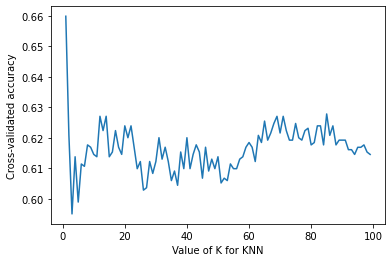

In [15]:
# Your code

k_range = range(1,100)
k_scores=[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k) 
    accuracy = cross_val_score(knn, wine_features_standardised_train, wine_labels_train, cv=4, scoring='accuracy') 
    k_scores.append(accuracy.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

**Discussion:**
We used the accuracy to score a model. What else could we score it on?

Your answer:

**Discussion:**

You have now trained your model several times. Discuss with your lab partner what the limitations and drawbacks of _k_-NN are.

Your answer:

## I. PCA and classification

**Exercise 10 (Optional):**

It can be helpful to use PCA to visualise data. 

- Apply PCA to the standardised features.
- Plot the scatter plot of first two PCs.
- You could also try making a seaborn pairplot of 3 or more PCs.
- Do the classes look more separable?

We can also use PCA as a pre-processing step.
- Would k-NN work better on features derived from PCA? If so, what is the best number of PCs to retain?

Text(0.5, 1.0, 'PCA of Wine Quality')

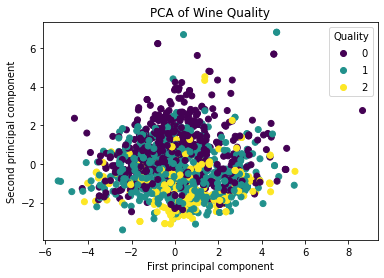

In [16]:
# Your code
pca = PCA(n_components=11).fit(wine_features_standardised)
pca_result = pca.transform(wine_features_standardised)

fig, ax = plt.subplots()
scatter = ax.scatter(x=pca_result[:, 0], y=pca_result[:, 1], c=wine_labels)
ax.legend(*scatter.legend_elements(),loc="upper right", title="Quality")
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_title('PCA of Wine Quality')



In [17]:
## We don't have answers for rest of this question - it's up to you to investigate